In [ ]:
import pandas as pd
import sqlite3
import os
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")
print(df.shape)
df.info()
df.head()


(59598, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Employee ID               59598 non-null  int64 
 1   Age                       59598 non-null  int64 
 2   Gender                    59598 non-null  object
 3   Years at Company          59598 non-null  int64 
 4   Job Role                  59598 non-null  object
 5   Monthly Income            59598 non-null  int64 
 6   Work-Life Balance         59598 non-null  object
 7   Job Satisfaction          59598 non-null  object
 8   Performance Rating        59598 non-null  object
 9   Number of Promotions      59598 non-null  int64 
 10  Overtime                  59598 non-null  object
 11  Distance from Home        59598 non-null  int64 
 12  Education Level           59598 non-null  object
 13  Marital Status            59598 non-null  object
 14  Number of 

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed


In [ ]:
df.isna().sum()

,0
Employee ID,0
Age,0
Gender,0
Years at Company,0
Job Role,0
Monthly Income,0
Work-Life Balance,0
Job Satisfaction,0
Performance Rating,0
Number of Promotions,0


In [ ]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except sqlite3.Error as e:
        print(e)
    return conn



def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name:
        try:
            conn.execute(f"DROP TABLE IF EXISTS {drop_table_name}")
        except sqlite3.Error as e:
            print(e)

    try:
        conn.execute(create_table_sql)
    except sqlite3.Error as e:
        print(e)




In [ ]:
def create_lookup_table(column_name, table_name, db_filename, data_filename):
    import sqlite3

    unique_values = set()
    with open(data_filename, "r", encoding="utf-8") as f:
        header = f.readline().strip().split(",")
        idx = header.index(column_name)
        for line in f:
            row = line.strip().split(",")
            if len(row) <= idx:
                continue
            value = row[idx].strip()
            if value:  # avoid blanks
                unique_values.add(value)

    conn = create_connection(db_filename)
    create_table(conn, f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            value TEXT UNIQUE
        );
    """, drop_table_name=table_name)

    for val in unique_values:
        try:
            conn.execute(f"INSERT INTO {table_name} (value) VALUES (?)", (val,))
        except sqlite3.IntegrityError:
            pass  # Skip duplicates safely

    conn.commit()
    conn.close()


In [ ]:
create_lookup_table("Gender", "Gender", "normalized_employee.db", "train.csv")
create_lookup_table("Job Role", "JobRole", "normalized_employee.db", "train.csv")
create_lookup_table("Work-Life Balance", "WorkLifeBalance", "normalized_employee.db", "train.csv")
create_lookup_table("Job Satisfaction", "JobSatisfaction", "normalized_employee.db", "train.csv")
create_lookup_table("Performance Rating", "PerformanceRating", "normalized_employee.db", "train.csv")
create_lookup_table("Education Level", "EducationLevel", "normalized_employee.db", "train.csv")
create_lookup_table("Marital Status", "MaritalStatus", "normalized_employee.db", "train.csv")
create_lookup_table("Job Level", "JobLevel", "normalized_employee.db", "train.csv")
create_lookup_table("Company Size", "CompanySize", "normalized_employee.db", "train.csv")
create_lookup_table("Attrition", "AttritionStatus", "normalized_employee.db", "train.csv")


In [ ]:
def build_all_id_dicts(db_filename):
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    lookup_tables = [
        "Gender", "JobRole", "WorkLifeBalance", "JobSatisfaction",
        "PerformanceRating", "EducationLevel", "MaritalStatus",
        "JobLevel", "CompanySize", "AttritionStatus"
    ]

    id_dicts = {}

    for table in lookup_tables:
        cursor.execute(f"SELECT id, value FROM {table}")
        id_dicts[table] = {value: id_ for id_, value in cursor.fetchall()}

    conn.close()
    return id_dicts


In [ ]:
id_dicts = build_all_id_dicts("normalized_employee.db")


In [ ]:
def create_employee_table(db_filename, data_filename, id_dicts):
    conn = create_connection(db_filename)
    create_table(conn, """
        CREATE TABLE IF NOT EXISTS Employee (
            employee_id INTEGER PRIMARY KEY,
            age INTEGER,
            years_at_company INTEGER,
            monthly_income INTEGER,
            number_of_promotions INTEGER,
            distance_from_home INTEGER,
            number_of_dependents INTEGER,
            company_tenure INTEGER,
            gender_id INTEGER,
            job_role_id INTEGER,
            wlb_id INTEGER,
            satisfaction_id INTEGER,
            rating_id INTEGER,
            education_level_id INTEGER,
            marital_status_id INTEGER,
            job_level_id INTEGER,
            company_size_id INTEGER,
            attrition_status_id INTEGER,
            FOREIGN KEY (gender_id) REFERENCES Gender(id),
            FOREIGN KEY (job_role_id) REFERENCES JobRole(id),
            FOREIGN KEY (wlb_id) REFERENCES WorkLifeBalance(id),
            FOREIGN KEY (satisfaction_id) REFERENCES JobSatisfaction(id),
            FOREIGN KEY (rating_id) REFERENCES PerformanceRating(id),
            FOREIGN KEY (education_level_id) REFERENCES EducationLevel(id),
            FOREIGN KEY (marital_status_id) REFERENCES MaritalStatus(id),
            FOREIGN KEY (job_level_id) REFERENCES JobLevel(id),
            FOREIGN KEY (company_size_id) REFERENCES CompanySize(id),
            FOREIGN KEY (attrition_status_id) REFERENCES AttritionStatus(id)
        );
    """, drop_table_name="Employee")

    with open(data_filename, "r", encoding="utf-8") as f:
        header = f.readline().strip().split(",")
        idx = {col: header.index(col) for col in header}

        for line in f:
            row = line.strip().split(",")
            try:
                values = (
                    int(row[idx["Employee ID"]]),
                    int(row[idx["Age"]]),
                    int(row[idx["Years at Company"]]),
                    int(row[idx["Monthly Income"]]),
                    int(row[idx["Number of Promotions"]]),
                    int(row[idx["Distance from Home"]]),
                    int(row[idx["Number of Dependents"]]),
                    int(row[idx["Company Tenure"]]),
                    id_dicts["Gender"][row[idx["Gender"]]],
                    id_dicts["JobRole"][row[idx["Job Role"]]],
                    id_dicts["WorkLifeBalance"][row[idx["Work-Life Balance"]]],
                    id_dicts["JobSatisfaction"][row[idx["Job Satisfaction"]]],
                    id_dicts["PerformanceRating"][row[idx["Performance Rating"]]],
                    id_dicts["EducationLevel"][row[idx["Education Level"]]],
                    id_dicts["MaritalStatus"][row[idx["Marital Status"]]],
                    id_dicts["JobLevel"][row[idx["Job Level"]]],
                    id_dicts["CompanySize"][row[idx["Company Size"]]],
                    id_dicts["AttritionStatus"][row[idx["Attrition"]]]
                )
                conn.execute("""
                    INSERT INTO Employee VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, values)
            except Exception as e:
                print("Skipping row due to error:", e)

    conn.commit()
    conn.close()


In [ ]:
create_employee_table("normalized_employee.db", "train.csv", id_dicts)

In [ ]:
conn = sqlite3.connect("normalized_employee.db")
df = pd.read_sql_query("SELECT * FROM Employee LIMIT 5", conn)
display(df)
conn.close()

,employee_id,age,years_at_company,monthly_income,number_of_promotions,distance_from_home,number_of_dependents,company_tenure,gender_id,job_role_id,wlb_id,satisfaction_id,rating_id,education_level_id,marital_status_id,job_level_id,company_size_id,attrition_status_id
0,1,56,41,5209,0,98,0,86,1,1,1,4,4,5,3,3,3,2
1,2,46,22,9099,0,13,0,93,2,5,1,2,4,4,3,3,1,1
2,3,32,16,4239,0,54,0,56,1,1,3,3,3,3,2,2,3,2
3,4,25,17,6834,0,62,2,26,2,2,1,3,4,2,2,3,1,1
4,6,56,23,12207,1,27,0,83,1,2,1,3,4,3,3,3,1,1


In [ ]:
conn = sqlite3.connect("normalized_employee.db")

In [ ]:
df_csv = pd.read_csv("train.csv")

1: Which job roles are most at risk for employee attrition?

In [ ]:
query_q1 = """
SELECT jr.value AS job_role,
       a.value AS attrition,
       COUNT(*) AS count
FROM Employee e
JOIN JobRole jr ON e.job_role_id = jr.id
JOIN AttritionStatus a ON e.attrition_status_id = a.id
GROUP BY jr.value, a.value
ORDER BY jr.value, a.value;
"""

pd.read_sql_query(query_q1, conn)

,job_role,attrition,count
0,Education,Left,6085
1,Education,Stayed,6405
2,Finance,Left,3924
3,Finance,Stayed,4461
4,Healthcare,Left,6454
5,Healthcare,Stayed,7188
6,Media,Left,4542
7,Media,Stayed,5032
8,Technology,Left,7333
9,Technology,Stayed,8174


2: How does job satisfaction relate to attrition?

In [ ]:
query_q2 = """
SELECT js.value AS job_satisfaction,
       a.value AS attrition,
       COUNT(*) AS count
FROM Employee e
JOIN JobSatisfaction js ON e.satisfaction_id = js.id
JOIN AttritionStatus a ON e.attrition_status_id = a.id
GROUP BY js.value, a.value
ORDER BY js.value, a.value;
"""

pd.read_sql_query(query_q2, conn)

,job_satisfaction,attrition,count
0,High,Left,13489
1,High,Stayed,16290
2,Low,Left,3088
3,Low,Stayed,2803
4,Medium,Left,5356
5,Medium,Stayed,6461
6,Very High,Left,6405
7,Very High,Stayed,5706


3: What’s the average income by job level and attrition status?

In [ ]:
query_q3 = """
SELECT jl.value AS job_level,
       a.value AS attrition,
       ROUND(AVG(e.monthly_income), 2) AS avg_income
FROM Employee e
JOIN JobLevel jl ON e.job_level_id = jl.id
JOIN AttritionStatus a ON e.attrition_status_id = a.id
GROUP BY jl.value, a.value
ORDER BY jl.value, a.value;
"""

pd.read_sql_query(query_q3, conn)

,job_level,attrition,avg_income
0,Entry,Left,7297.46
1,Entry,Stayed,7372.89
2,Mid,Left,7258.20
3,Mid,Stayed,7296.33
4,Senior,Left,7230.18
5,Senior,Stayed,7322.06


4: Is there any pattern between education level and attrition?

In [ ]:
query_q4 = """
SELECT ed.value AS education_level,
       a.value AS attrition,
       COUNT(*) AS count
FROM Employee e
JOIN EducationLevel ed ON e.education_level_id = ed.id
JOIN AttritionStatus a ON e.attrition_status_id = a.id
GROUP BY ed.value, a.value
ORDER BY ed.value, a.value;
"""

pd.read_sql_query(query_q4, conn)

,education_level,attrition,count
0,Associate Degree,Left,7230
1,Associate Degree,Stayed,7685
2,Bachelor’s Degree,Left,8791
3,Bachelor’s Degree,Stayed,9035
4,High School,Left,5668
5,High School,Stayed,6080
6,Master’s Degree,Left,5881
7,Master’s Degree,Stayed,6139
8,PhD,Left,768
9,PhD,Stayed,2321


5: How does work-life balance rating correlate with attrition?

In [ ]:
query_q5 = """
SELECT wlb.value AS work_life_balance,
       a.value AS attrition,
       COUNT(*) AS count
FROM Employee e
JOIN WorkLifeBalance wlb ON e.wlb_id = wlb.id
JOIN AttritionStatus a ON e.attrition_status_id = a.id
GROUP BY wlb.value, a.value
ORDER BY wlb.value, a.value;
"""

pd.read_sql_query(query_q5, conn)

,work_life_balance,attrition,count
0,Excellent,Left,3839
1,Excellent,Stayed,6880
2,Fair,Left,10370
3,Fair,Stayed,7676
4,Good,Left,9137
5,Good,Stayed,13391
6,Poor,Left,4992
7,Poor,Stayed,3313


# **PANDAS**

Q1

In [ ]:
df_attrition_csv = (
    df_csv.groupby(["Job Role", "Attrition"])
    .size()
    .reset_index(name="count")
    .sort_values(["Job Role", "Attrition"])
)

display(df_attrition_csv)

,Job Role,Attrition,count
0,Education,Left,6085
1,Education,Stayed,6405
2,Finance,Left,3924
3,Finance,Stayed,4461
4,Healthcare,Left,6454
5,Healthcare,Stayed,7188
6,Media,Left,4542
7,Media,Stayed,5032
8,Technology,Left,7333
9,Technology,Stayed,8174


Q2

In [ ]:
df_satisfaction_csv = (
    df_csv.groupby(["Job Satisfaction", "Attrition"])
    .size()
    .reset_index(name="count")
    .sort_values(["Job Satisfaction", "Attrition"])
)
display(df_satisfaction_csv)

,Job Satisfaction,Attrition,count
0,High,Left,13489
1,High,Stayed,16290
2,Low,Left,3088
3,Low,Stayed,2803
4,Medium,Left,5356
5,Medium,Stayed,6461
6,Very High,Left,6405
7,Very High,Stayed,5706


Q3

In [ ]:
df_income_csv = (
    df_csv.groupby(["Job Level", "Attrition"])["Monthly Income"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"Monthly Income": "avg_income"})
    .sort_values(["Job Level", "Attrition"])
)

display(df_income_csv)

,Job Level,Attrition,avg_income
0,Entry,Left,7297.46
1,Entry,Stayed,7372.89
2,Mid,Left,7258.20
3,Mid,Stayed,7296.33
4,Senior,Left,7230.18
5,Senior,Stayed,7322.06


Q4

In [ ]:
df_education_csv = (
    df_csv.groupby(["Education Level", "Attrition"])
    .size()
    .reset_index(name="count")
    .sort_values(["Education Level", "Attrition"])
)
display(df_education_csv)

,Education Level,Attrition,count
0,Associate Degree,Left,7230
1,Associate Degree,Stayed,7685
2,Bachelor’s Degree,Left,8791
3,Bachelor’s Degree,Stayed,9035
4,High School,Left,5668
5,High School,Stayed,6080
6,Master’s Degree,Left,5881
7,Master’s Degree,Stayed,6139
8,PhD,Left,768
9,PhD,Stayed,2321


Q5

In [ ]:
df_wlb_csv = (
    df_csv.groupby(["Work-Life Balance", "Attrition"])
    .size()
    .reset_index(name="count")
    .sort_values(["Work-Life Balance", "Attrition"])
)
display(df_wlb_csv)

,Work-Life Balance,Attrition,count
0,Excellent,Left,3839
1,Excellent,Stayed,6880
2,Fair,Left,10370
3,Fair,Stayed,7676
4,Good,Left,9137
5,Good,Stayed,13391
6,Poor,Left,4992
7,Poor,Stayed,3313


# **VISUALIZATION**

Q1

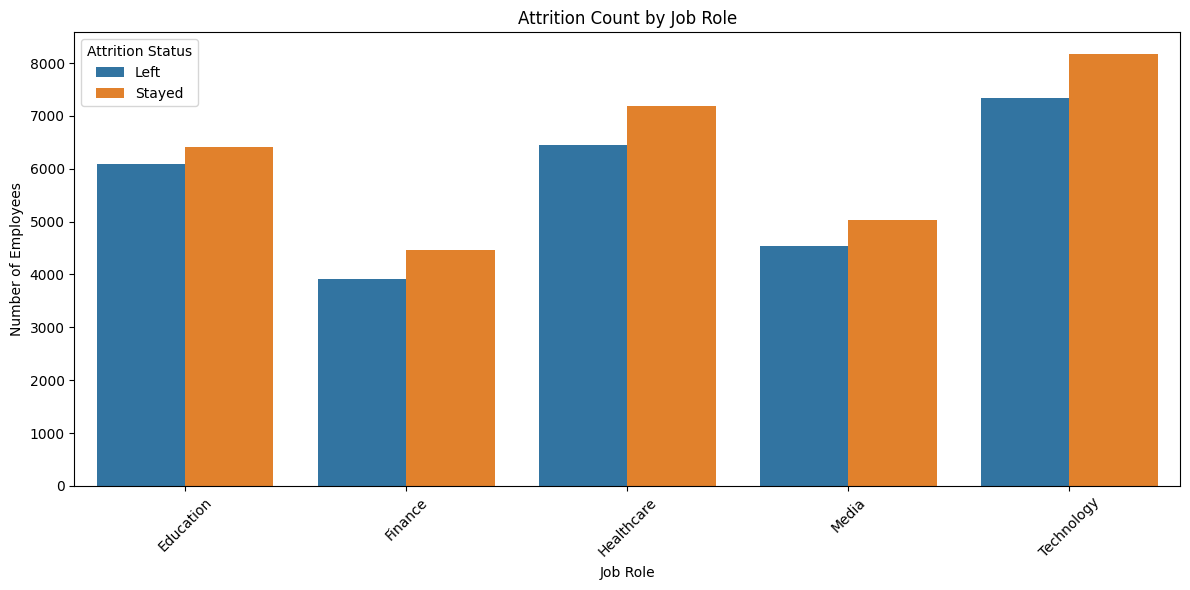

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_attrition_csv, x="Job Role", y="count", hue="Attrition")

plt.title("Attrition Count by Job Role")
plt.xlabel("Job Role")
plt.ylabel("Number of Employees")
plt.xticks(rotation=45)
plt.legend(title="Attrition Status")
plt.tight_layout()
plt.show()

Q2

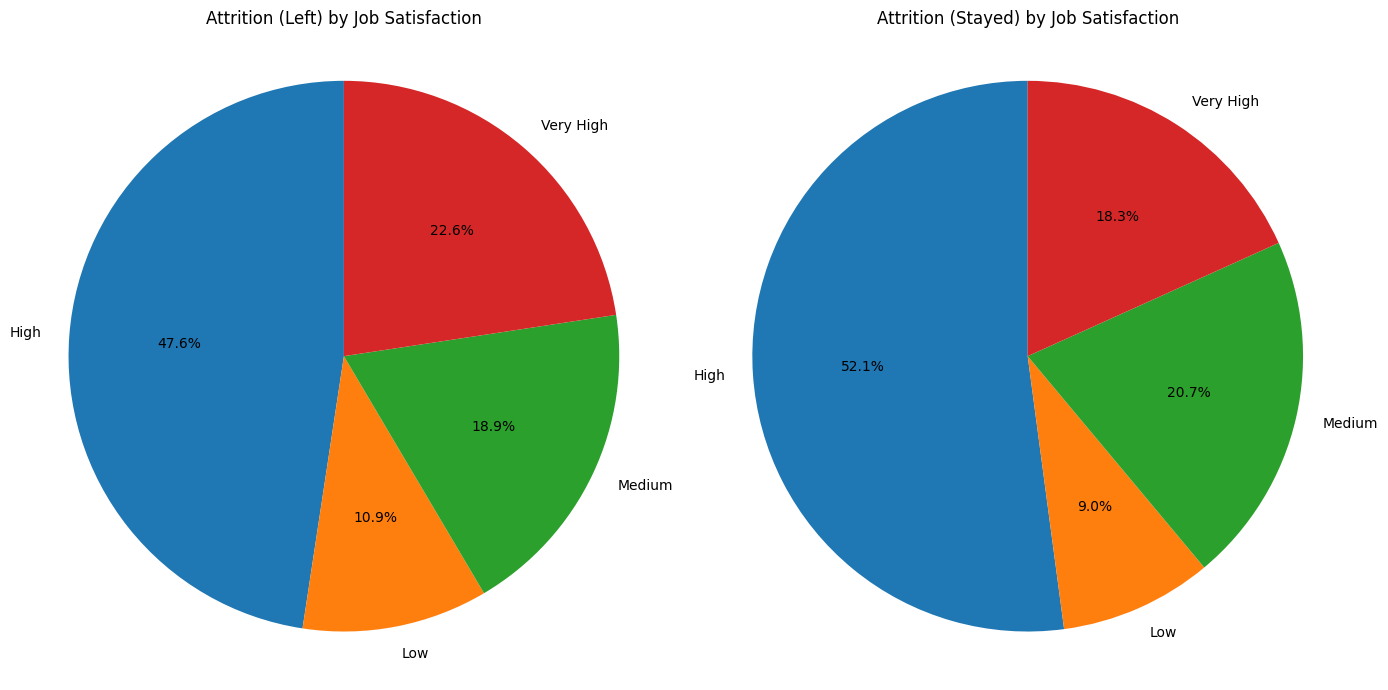

In [ ]:
left_counts = df_satisfaction_csv[df_satisfaction_csv["Attrition"] == "Left"].set_index("Job Satisfaction")["count"]
stayed_counts = df_satisfaction_csv[df_satisfaction_csv["Attrition"] == "Stayed"].set_index("Job Satisfaction")["count"]
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(left_counts, labels=left_counts.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Attrition (Left) by Job Satisfaction")
axes[0].axis("equal")  # Equal aspect ratio to ensure it's a circle

axes[1].pie(stayed_counts, labels=stayed_counts.index, autopct="%1.1f%%", startangle=90)
axes[1].set_title("Attrition (Stayed) by Job Satisfaction")
axes[1].axis("equal")

plt.tight_layout()
plt.show()



Q3

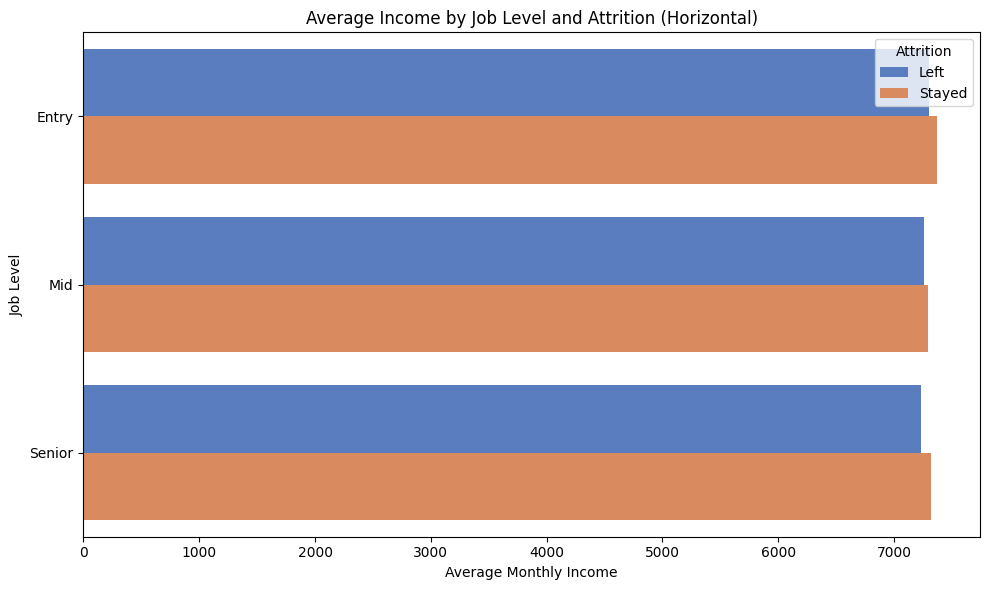

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_income_csv, y="Job Level", x="avg_income", hue="Attrition", orient="h", palette="muted") # Try "Set1", "Set2", "Set3", "pastel", "muted"

plt.title("Average Income by Job Level and Attrition (Horizontal)")
plt.xlabel("Average Monthly Income")
plt.ylabel("Job Level")
plt.legend(title="Attrition")
plt.tight_layout()
plt.show()


Q4

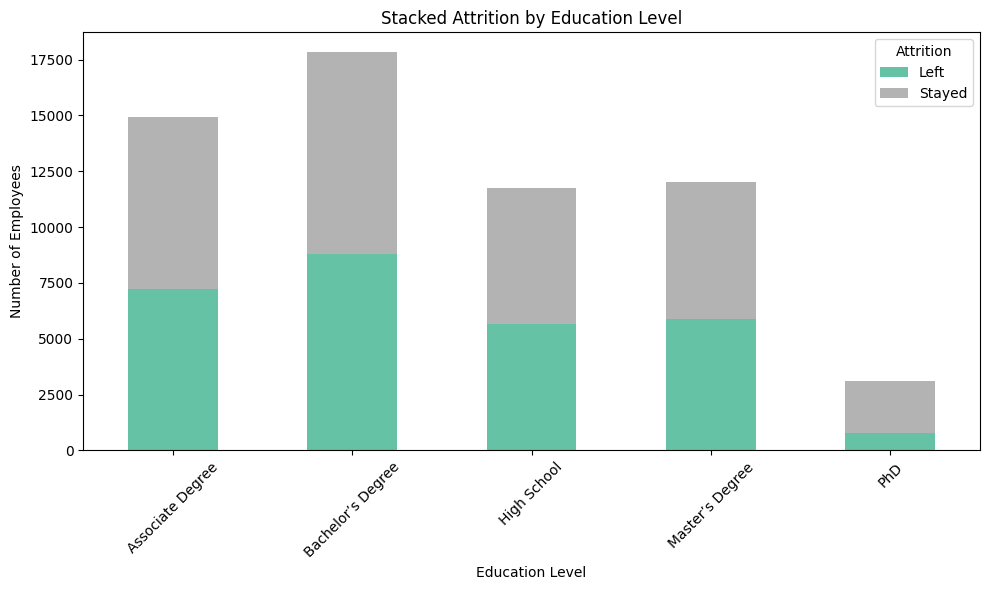

In [ ]:
edu_pivot = df_education_csv.pivot(index="Education Level", columns="Attrition", values="count")
edu_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="Set2"
)

plt.title("Stacked Attrition by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Number of Employees")
plt.legend(title="Attrition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Q5

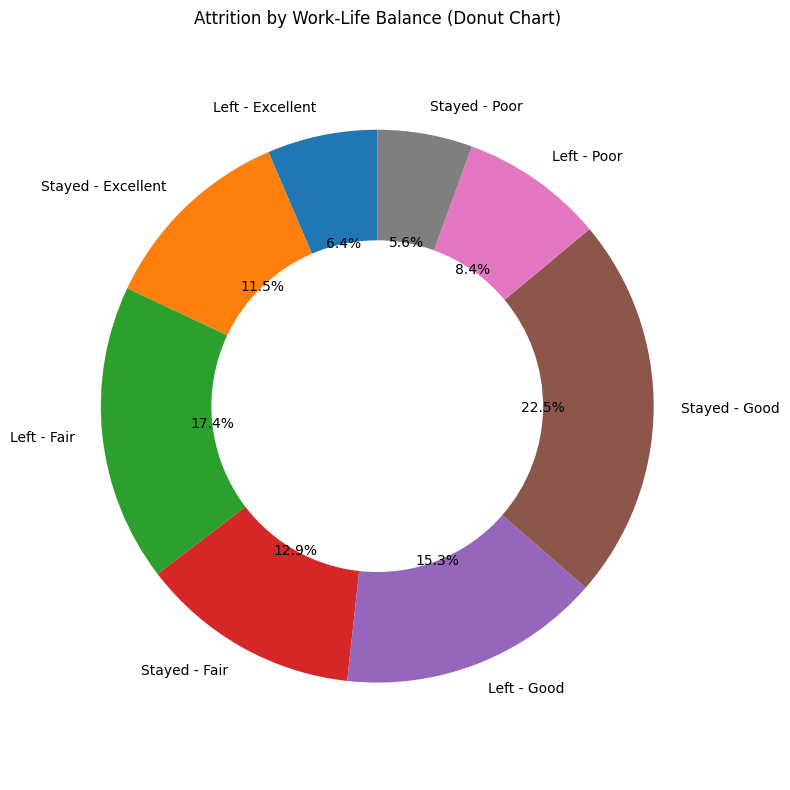

In [ ]:
import matplotlib.pyplot as plt

# Combine labels and counts
df_combined = df_wlb_csv.copy()
df_combined["label"] = df_combined["Attrition"] + " - " + df_combined["Work-Life Balance"]

# Data for the pie chart
counts = df_combined["count"]
labels = df_combined["label"]

# Create donut chart
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"width": 0.4}
)

plt.title("Attrition by Work-Life Balance (Donut Chart)")
plt.axis("equal")
plt.tight_layout()
plt.show()
